#📌 Extracción

In [4]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)

# URL cruda del JSON en GitHub
URL = "https://raw.githubusercontent.com/alura-cursos/challenge2-data-science-LATAM/main/TelecomX_Data.json"

# Descargar JSON y aplanar
raw = requests.get(URL).json()
df = pd.json_normalize(raw, sep="_")  # aplanado: customer_* phone_* internet_* account_* etc.

print(df.shape)
df.head()


(7267, 21)


,customerID,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,internet_OnlineSecurity,internet_OnlineBackup,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges_Monthly,account_Charges_Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,No,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


#🔧 Transformación

In [5]:
# 3.1 Quitar duplicados (prioriza ID si existe)
if COL_ID:
    df.drop_duplicates(subset=[COL_ID], inplace=True)
else:
    df.drop_duplicates(inplace=True)

# 3.2 Normalizar valores tipo Yes/No → 1/0, manteniendo otras categorías
yn_map = {'Yes': 1, 'No': 0, 'yes': 1, 'no': 0, 'Y': 1, 'N': 0, True: 1, False: 0}
obj_cols = df.select_dtypes(include="object").columns
for c in obj_cols:
    # Solo mapear si la columna está formada solo por Yes/No/NaN (para no romper otras categorías)
    uniques = pd.Series(df[c].dropna().unique())
    if not uniques.empty and uniques.isin(list(yn_map.keys())).all():
        df[c] = df[c].map(yn_map)

# 3.3 Convertir a numérico columnas clásicas si existen
numeric_targets = [COL_MONTHLY, COL_TOTAL, COL_TENURE, COL_SENIOR]
for col in [c for c in numeric_targets if c]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# 3.4 Imputación simple para numéricos
for c in df.select_dtypes(include=[np.number]).columns:
    if df[c].isna().any():
        df[c] = df[c].fillna(df[c].median())

# 3.5 Limpieza final de espacios/cadenas
for c in df.select_dtypes(include="object").columns:
    df[c] = df[c].astype(str).str.strip()

# 3.6 Validación rápida
print("Filas/columnas:", df.shape)
display(df.isnull().sum().sort_values(ascending=False).head(10))
df.head(3)


Filas/columnas: (7267, 21)


,0
customerID,0
Churn,0
customer_gender,0
customer_SeniorCitizen,0
customer_Partner,0
customer_Dependents,0
customer_tenure,0
phone_PhoneService,0
phone_MultipleLines,0
internet_InternetService,0


,customerID,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,internet_OnlineSecurity,internet_OnlineBackup,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges_Monthly,account_Charges_Total
0,0002-ORFBO,No,Female,0,1,1,9,1,No,DSL,No,Yes,No,Yes,Yes,No,One year,1,Mailed check,65.6,593.30
1,0003-MKNFE,No,Male,0,0,0,9,1,Yes,DSL,No,No,No,No,No,Yes,Month-to-month,0,Mailed check,59.9,542.40
2,0004-TLHLJ,Yes,Male,0,0,0,4,1,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,1,Electronic check,73.9,280.85


#📊 Carga y análisis

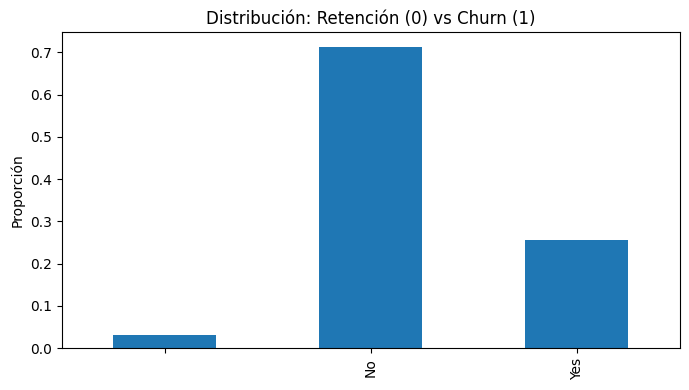

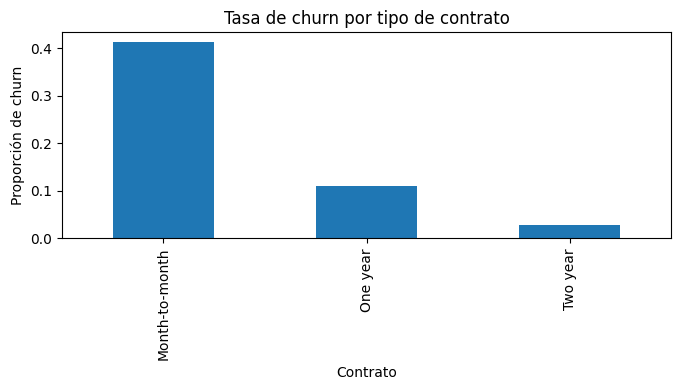

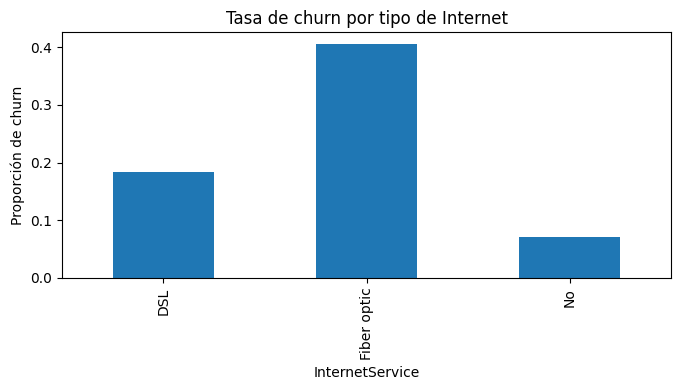

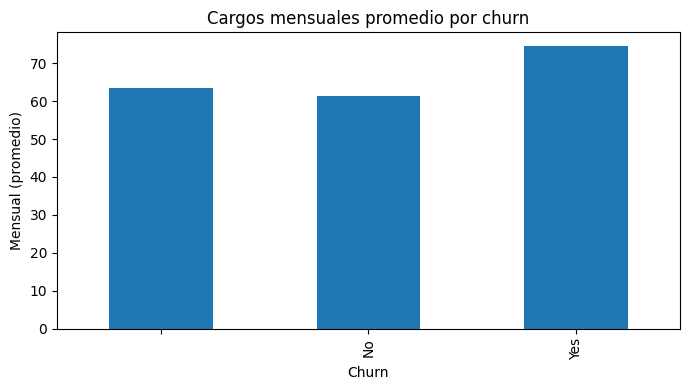

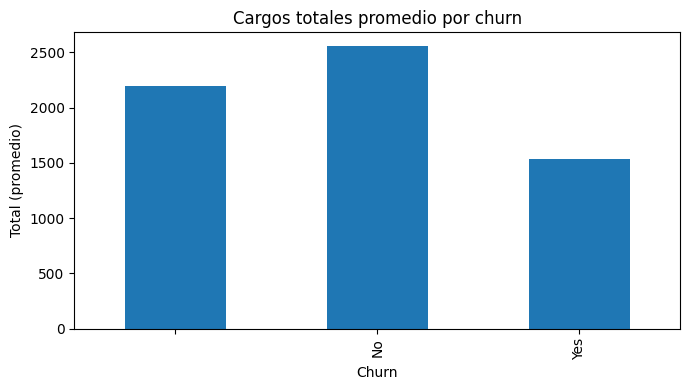

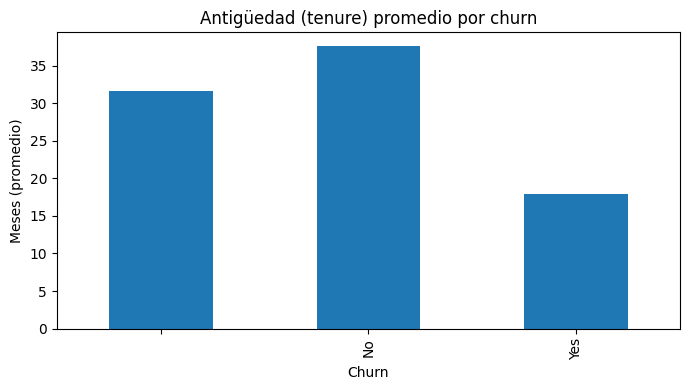

In [6]:
# Helper para graficar barras simples
def plot_bar(series, title, xlabel="", ylabel=""):
    ax = series.plot(kind="bar", figsize=(7,4))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

# 4.1 Distribución de Churn
if COL_CHURN:
    churn_dist = df[COL_CHURN].value_counts(normalize=True).sort_index()
    plot_bar(churn_dist, "Distribución: Retención (0) vs Churn (1)", ylabel="Proporción")

# 4.2 Churn por tipo de contrato
if COL_CHURN and COL_CONTRACT:
    ctab_contract = pd.crosstab(df[COL_CONTRACT], df[COL_CHURN], normalize="index")
    plot_bar(ctab_contract[1] if 1 in ctab_contract.columns else ctab_contract.iloc[:, -1],
             "Tasa de churn por tipo de contrato", xlabel="Contrato", ylabel="Proporción de churn")

# 4.3 Churn por tipo de internet
if COL_CHURN and COL_ISP:
    ctab_isp = pd.crosstab(df[COL_ISP], df[COL_CHURN], normalize="index")
    plot_bar(ctab_isp[1] if 1 in ctab_isp.columns else ctab_isp.iloc[:, -1],
             "Tasa de churn por tipo de Internet", xlabel="InternetService", ylabel="Proporción de churn")

# 4.4 Cargos mensuales / totales por churn
if COL_CHURN and COL_MONTHLY:
    plot_bar(df.groupby(COL_CHURN)[COL_MONTHLY].mean(),
             "Cargos mensuales promedio por churn", xlabel="Churn", ylabel="Mensual (promedio)")

if COL_CHURN and COL_TOTAL:
    plot_bar(df.groupby(COL_CHURN)[COL_TOTAL].mean(),
             "Cargos totales promedio por churn", xlabel="Churn", ylabel="Total (promedio)")

# 4.5 Tenure por churn (antigüedad)
if COL_CHURN and COL_TENURE:
    plot_bar(df.groupby(COL_CHURN)[COL_TENURE].mean(),
             "Antigüedad (tenure) promedio por churn", xlabel="Churn", ylabel="Meses (promedio)")


#📄Informe final

In [8]:
# 🔧 Normalizar CHURN a binario 0/1 de forma robusta
import numpy as np

assert COL_CHURN is not None, "No se detectó la columna de churn"

_ch = df[COL_CHURN].astype(str).str.strip().str.lower()

df[COL_CHURN] = np.where(
    _ch.isin(['1', 'yes', 'true', 'y', 'si', 'sí']),
    1,
    np.where(_ch.isin(['0', 'no', 'false', 'n']), 0, np.nan)
)

# Imputar cualquier NaN con la moda y dejar int
if df[COL_CHURN].isna().any():
    df[COL_CHURN] = df[COL_CHURN].fillna(df[COL_CHURN].mode().iloc[0])

df[COL_CHURN] = df[COL_CHURN].astype(int)

# Verificación rápida
print(df[COL_CHURN].value_counts(dropna=False))
print("dtype:", df[COL_CHURN].dtype)


Churn
0    5398
1    1869
Name: count, dtype: int64
dtype: int64


In [9]:
conclusiones = []

tasa = df[COL_CHURN].mean()
conclusiones.append(f"- Tasa general de churn: {tasa:.2%}")

if COL_CONTRACT:
    churn_por_contrato = pd.crosstab(df[COL_CONTRACT], df[COL_CHURN], normalize="index")
    if 1 in churn_por_contrato.columns:
        worst_contract = churn_por_contrato[1].idxmax()
        conclusiones.append(f"- Mayor churn en el contrato: {worst_contract} ({churn_por_contrato[1].max():.2%})")

if COL_ISP:
    churn_por_isp = pd.crosstab(df[COL_ISP], df[COL_CHURN], normalize="index")
    if 1 in churn_por_isp.columns:
        worst_isp = churn_por_isp[1].idxmax()
        conclusiones.append(f"- Tipo de internet con más churn: {worst_isp} ({churn_por_isp[1].max():.2%})")

if COL_MONTHLY:
    m = df.groupby(COL_CHURN)[COL_MONTHLY].mean()
    if {0,1}.issubset(m.index):
        conclusiones.append(f"- Clientes que se dan de baja pagan más al mes: {m[1]:.2f} vs {m[0]:.2f}")

if COL_TENURE:
    t = df.groupby(COL_CHURN)[COL_TENURE].mean()
    if {0,1}.issubset(t.index):
        conclusiones.append(f"- Antigüedad promedio (churn vs no-churn): {t[1]:.1f} vs {t[0]:.1f} meses")

print("## Conclusiones preliminares – Telecom X\n")
for linea in conclusiones:
    print(linea)

## Conclusiones preliminares – Telecom X

- Tasa general de churn: 25.72%
- Mayor churn en el contrato: Month-to-month (41.32%)
- Tipo de internet con más churn: Fiber optic (40.56%)
- Clientes que se dan de baja pagan más al mes: 74.44 vs 61.35
- Antigüedad promedio (churn vs no-churn): 18.0 vs 37.3 meses


# README

Checklist README:
- Objetivo: ETL de datos de churn para Telecom X.
- Extract: lectura JSON desde GitHub (requests + json_normalize).
- Transform: duplicados, mapeo Yes/No, numéricos, imputación.
- EDA: gráficos de distribución de churn, contrato, internet, cargos, tenure.
- Conclusiones: 3 - 5 bullets con hallazgos y recomendaciones.